# Winds pre-processing in RCM:

Take last non NaN value for wind pressure levels in RCM data.

## Setting up:

In [1]:
# run script that installs missing libraries
! chmod 755 ../../scripts.sh
! ../../scripts.sh

  Using cached google_cloud_storage-2.3.0-py2.py3-none-any.whl (107 kB)
  Using cached google_cloud_storage-2.2.1-py2.py3-none-any.whl (107 kB)


In [11]:
import os
import sys

from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs
import gcsfs
from tqdm import tqdm
import pyproj
from pyproj import Transformer
from google.cloud import storage
from re import search
from os import listdir
from os.path import isfile, join
from scipy import ndimage

# import self made python files
sys.path.append('../')
from process_pangeo import *
from GC_scripts import *
from processRCM import *
from reprojectionFunctions import *
import multiprocessing as mp

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Google cloud
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

os.environ["GCLOUD_PROJECT"] = PROJECT
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

## Functions:

In [13]:
def findLastNonNanTime(time0, f0, VAR):
    a = np.empty((f0.dims["y"], f0.dims["x"]))  # shape (y,x)
    b = np.empty((f0.dims["y"], f0.dims["x"]))  # shape (y,x)

    ynumb = 0
    for y0 in f0.y.values:
        d = pd.DataFrame(f0.sel(time=time0, y=y0)[VAR].values)
        # indices of last non nan values
        idx = d.apply(pd.Series.last_valid_index)
        # last non nan values
        nonNan = pd.Series([d.iloc[plev, column] for column, plev in idx.iteritems()])

        a[ynumb, :] = idx
        b[ynumb, :] = nonNan
        ynumb += 1

    return a, b

def HighToNan(d0, plev, atm):
    f0 = xr.Dataset(xr.where(d0[VAR]<90, d0, np.nan), coords = d0.coords, attrs = d0.attrs)
    f0[VAR].attrs = d0[VAR].attrs # Var attrs
    f0.x.attrs = d0.x.attrs # Coords attrs
    f0.y.attrs = d0.y.attrs 
    if plev:
        f0.PLEV.attrs = d0.PLEV.attrs 
    if atm:
        f0.ATMLAY.attrs = d0.ATMLAY.attrs 
    return f0

def plotAllVar(GCM_xy, m=3, n=3, name='GCM'):
    vars_ = list(GCM_xy.data_vars)
    coords = list(GCM_xy.coords)
    f = plt.figure(figsize=(20, 10))
    map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    for i in range(len(vars_)):
        var = vars_[i]
        ax = plt.subplot(m, n, i + 1, projection=ccrs.SouthPolarStereo())
        GCM_xy[var].isel(time=0).plot(ax=ax, x='x', y='y',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)
        ax.coastlines('10m', color='black')
        ax.gridlines()
        ax.set_title(f'{GCM_xy[var].long_name} ({var})')
    plt.suptitle(f'First time step {GCM_xy.time[0].values} of {name}')

In [14]:
def PreProcWinds(d0, VAR, plev = True, atm=False):
    # select values that are not nan
    # nb: nan values were given very high value, change to nan
    f0 = HighToNan(d0, plev=plev, atm=atm)

    A, B = [], []

    # For each time step t get a matrix of shape (plev, y, x)
    # For each value of y (rownmb) and x (colnmb) want to find plev that is the last non nan value
    Time = len(f0.time)  # all time steps

    y = f0.dims["y"]
    x = f0.dims["x"]

    for j in range(Time):  # for each time step
        time0 = f0.time[j].values  # time-step

        a, b = findLastNonNanTime(time0, f0, VAR)

        A.append(a)
        B.append(b)

    dLastNan = xr.Dataset(coords=f0.coords, attrs=f0.attrs)
    dLastNan[VAR] = xr.Variable(dims=("time", "y", "x"), data=B, attrs=f0[VAR].attrs)
    
    dLastInd = xr.Dataset(coords=f0.coords, attrs=f0.attrs)
    dLastInd[VAR] = xr.Variable(dims=("time", "y", "x"), data=A, attrs=f0[VAR].attrs)
    return dLastNan, dLastInd


## Take last Non Nan:

### Test on one timestep and var:

In [15]:
# test on one year and one variable
VAR = "VVP"
pathGC, fileGC = pathToFiles(VAR, date1="19800101", date2="19801231")
downloadFileFromGC(pathGC, "", fileGC)
d0 = xr.open_dataset(fileGC)
d0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, d0)))
os.remove(fileGC)

# Change high values to NaN
f0 = xr.Dataset(xr.where(d0[VAR] < 90, d0, np.nan), coords=d0.coords, attrs=d0.attrs)
f0[VAR].attrs = d0[VAR].attrs
f0.x.attrs = d0.x.attrs
f0.y.attrs = d0.y.attrs
f0.PLEV.attrs = d0.PLEV.attrs
f0

<xarray.Dataset>
Dimensions:      (time: 12, PLEV: 7, y: 148, x: 176)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 1980-12-31
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
    spatial_ref  int64 0
Data variables:
    VVP          (time, PLEV, y, x) float32 20.15 19.62 19.07 ... -10.28 -10.4
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 11:51:03 2022: ncap2 -O -s VVP...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

TypeError: HighToNan() missing 2 required positional arguments: 'plev' and 'atm'

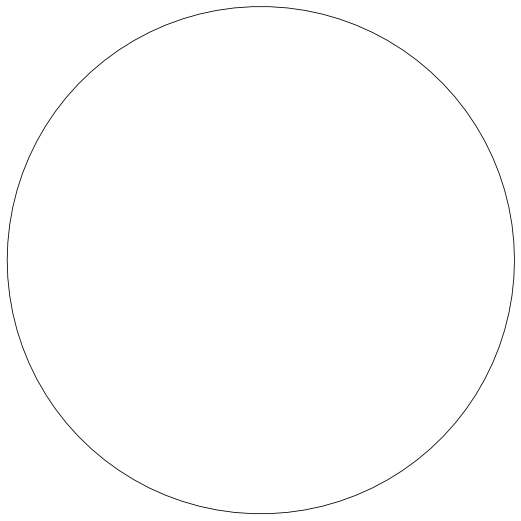

In [16]:
f = plt.figure(figsize=(20, 10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)

ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
f0 = HighToNan(d0, plev = True, atm = False)
f0.isel(time=0, PLEV = 5).VVP.plot(ax=ax, x='x',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)

ax.coastlines('10m', color='black')
ax.gridlines()
ax.set_title(f'{f0[VAR].long_name} ({VAR}), PLEV = 5')

ax = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
f0 = HighToNan(d0, plev = True, atm = False)
d0.isel(time=0, PLEV = 5).VVP.plot(ax=ax, x='x',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)

ax.coastlines('10m', color='black')
ax.gridlines()
ax.set_title(f'{d0[VAR].long_name} ({VAR}), PLEV = 5, w/o NaN')

Test of find last non nan values function:

In [ ]:
%%time
dLastNan, dLastInd = PreProcWinds(d0, VAR, plev = True, atm = False)

f = plt.figure(figsize=(20, 10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)

ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
f0 = HighToNan(d0, plev = True, atm = False)
dLastNan.isel(time=0).VVP.plot(ax=ax, x='x',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)

ax.coastlines('10m', color='black')
ax.gridlines()
ax.set_title(f'{f0[VAR].long_name} ({VAR}), surface value')

ax = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
f0 = HighToNan(d0, plev = True, atm = False)
dLastInd.isel(time=0).VVP.plot(ax=ax, x='x',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)

ax.coastlines('10m', color='black')
ax.gridlines()
ax.set_title(f'{d0[VAR].long_name} ({VAR}), surface plevls')

### Apply to all winds:

In [ ]:
vars_= ['VVP','UUP']
! rm -r ../../../data/tmp_winds/*

download = True
if download:
    for VAR in vars_:
        print(f'{VAR}:\n--------------')
        pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
        pathLocal = '../../../data/tmp_winds/'
        filesGC = listFilesGC(pathGC, VAR)

        #------ Download files from GC
        print('Downloading files from GC')
        downloadFilesFromGC(pathGC, pathLocal, filesGC)

        onlyfiles = filesInDirWithVar(pathLocal, VAR)
        print('Examples of files: \n {}'.format(onlyfiles[0]))

        #------ concatenate all years of a variable
        # first year
        if len(onlyfiles) == 121:
            print('Concatenating...')
            f0 = xr.open_dataset(pathLocal+onlyfiles[0])
            # preprocessing and resampling
            f0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, f0)))
            
            # preprocessing of winds
            df0, dLastInd = PreProcWinds(f0, VAR, plev = True, atm = False)
            
            for i in tqdm(range(1, len(onlyfiles))):
                f = onlyfiles[i]
                f0 = xr.open_dataset(pathLocal+f)
                # preprocessing and resampling
                f0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, f0)))
                
                # preprocessing of winds
                df, dLastInd = PreProcWinds(f0, VAR, plev = True, atm = False)
        
                # concatenate with previous years
                df0 = xr.concat([df0,df], dim = 'time')

            # save file locally:
            path = '../../../data/toGC/'
            name = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly_spwinds.nc'
            df0.to_netcdf(name)

            # upload to GC:
            print('Uploading to GC...')
            pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
            uploadFileToGC(pathGC, name)

            # delete file and temporary directory:
            os.remove(name)
            ! rm ../../data/tmp_winds/*

        else:
            print(f'Error: len only files is:{len(onlyfiles)}')
            break

rm: cannot remove '../../data/tmp_winds/*': No such file or directory
VVP:
--------------


100%|██████████| 121/121 [07:29<00:00,  3.72s/it]


Examples of files: 
 VVP_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc
Concatenating...


100%|██████████| 120/120 [36:59<00:00, 18.50s/it]


Uploading to GC...
UUP:
--------------


 78%|███████▊  | 94/121 [06:33<01:40,  3.71s/it]

### Apply to specific humidity and temperature:

In [17]:
# test on one year and one variable
VAR = "QQP"
pathGC, fileGC = pathToFiles(VAR, date1="19800101", date2="19801231")
downloadFileFromGC(pathGC, "", fileGC)
d0 = xr.open_dataset(fileGC)
d0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, d0)))
os.remove(fileGC)

# Change high values to NaN
f0 = xr.Dataset(xr.where(d0[VAR] < 90, d0, np.nan), coords=d0.coords, attrs=d0.attrs)
f0[VAR].attrs = d0[VAR].attrs
f0.x.attrs = d0.x.attrs
f0.y.attrs = d0.y.attrs
f0.PLEV.attrs = d0.PLEV.attrs
f0

<xarray.Dataset>
Dimensions:      (time: 12, PLEV: 7, y: 148, x: 176, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 1980-12-31
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
    spatial_ref  int64 0
Dimensions without coordinates: bnds
Data variables:
    QQP          (time, PLEV, y, x) float32 0.01594 0.01571 ... 3.381 3.406
    PLEV_bnds    (time, PLEV, y, x, bnds) float32 50.0 350.0 ... 887.5 962.5
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 11:19:02 2022: ncap2 -O -s QQP...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

Text(0.5, 1.0, 'Specific Humidity (QQP), PLEV = 5, w/o NaN')

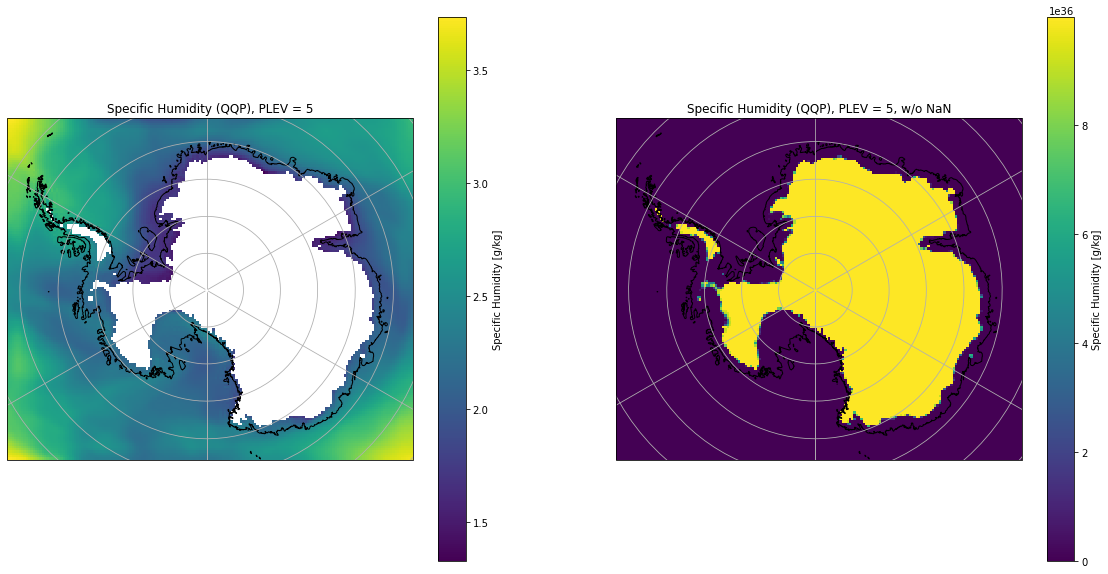

In [18]:
f = plt.figure(figsize=(20, 10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)

ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
f0 = HighToNan(d0, plev = True, atm = False)
f0.isel(time=0, PLEV = 5)[VAR].plot(ax=ax, x='x',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)

ax.coastlines('10m', color='black')
ax.gridlines()
ax.set_title(f'{f0[VAR].long_name} ({VAR}), PLEV = 5')

ax = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
f0 = HighToNan(d0, plev = True, atm = False)
d0.isel(time=0, PLEV = 5)[VAR].plot(ax=ax, x='x',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)

ax.coastlines('10m', color='black')
ax.gridlines()
ax.set_title(f'{d0[VAR].long_name} ({VAR}), PLEV = 5, w/o NaN')

CPU times: user 15.3 s, sys: 1.13 ms, total: 15.3 s
Wall time: 15.3 s


Text(0.5, 1.0, 'Specific Humidity (QQP), surface plevls')

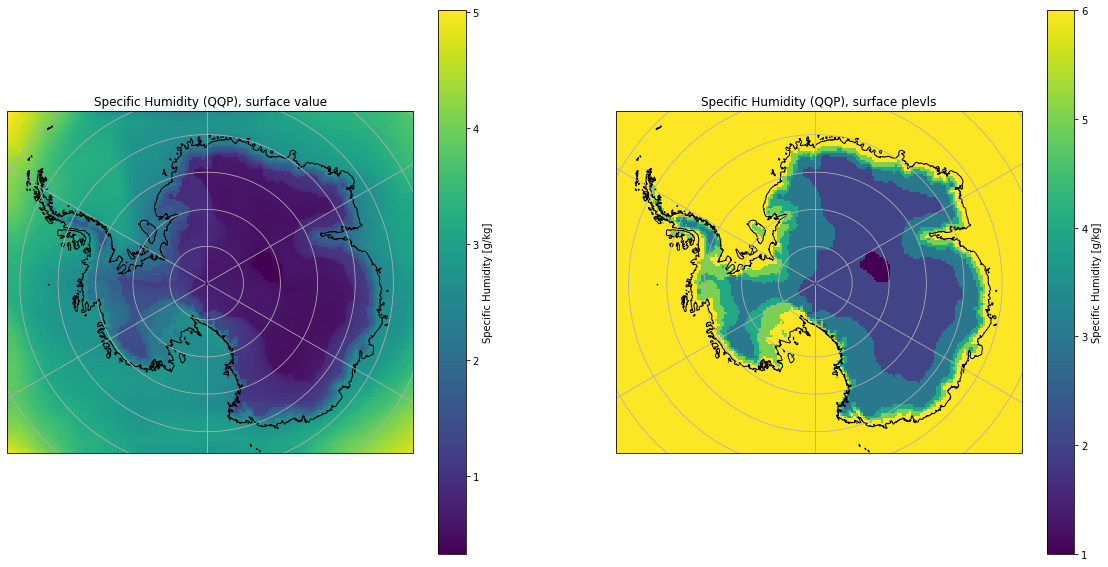

In [19]:
%%time
dLastNan, dLastInd = PreProcWinds(d0, VAR, plev = True, atm = False)

f = plt.figure(figsize=(20, 10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)

ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
f0 = HighToNan(d0, plev = True, atm = False)
dLastNan.isel(time=0)[VAR].plot(ax=ax, x='x',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)

ax.coastlines('10m', color='black')
ax.gridlines()
ax.set_title(f'{f0[VAR].long_name} ({VAR}), surface value')

ax = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
f0 = HighToNan(d0, plev = True, atm = False)
dLastInd.isel(time=0)[VAR].plot(ax=ax, x='x',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)

ax.coastlines('10m', color='black')
ax.gridlines()
ax.set_title(f'{d0[VAR].long_name} ({VAR}), surface plevls')

In [22]:
vars_= ['QQP','TTP']
! rm -r ../../../data/tmp_winds/*

download = True
if download:
    for VAR in vars_:
        print(f'{VAR}:\n--------------')
        pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
        pathLocal = '../../../data/tmp_winds/'
        filesGC = listFilesGC(pathGC, VAR)

        #------ Download files from GC
        print('Downloading files from GC')
        downloadFilesFromGC(pathGC, pathLocal, filesGC)

        onlyfiles = filesInDirWithVar(pathLocal, VAR)
        print('Examples of files: \n {}'.format(onlyfiles[0]))

        #------ concatenate all years of a variable
        # first year
        if len(onlyfiles) == 121:
            print('Concatenating...')
            f0 = xr.open_dataset(pathLocal+onlyfiles[0])
            # preprocessing and resampling
            f0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, f0)))
            
            # preprocessing of winds
            df0, dLastInd = PreProcWinds(f0, VAR, plev = True, atm = False)
            
            for i in tqdm(range(1, len(onlyfiles))):
                f = onlyfiles[i]
                f0 = xr.open_dataset(pathLocal+f)
                # preprocessing and resampling
                f0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, f0)))
                
                # preprocessing of winds
                df, dLastInd = PreProcWinds(f0, VAR, plev = True, atm = False)
        
                # concatenate with previous years
                df0 = xr.concat([df0,df], dim = 'time')

            # save file locally:
            path = '../../../data/toGC/'
            name = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly_spvars.nc'
            df0.to_netcdf(name)

            # upload to GC:
            print('Uploading to GC...')
            pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
            uploadFileToGC(pathGC, name)

            # delete file and temporary directory:
            os.remove(name)
            ! rm ../../data/tmp_winds/*

        else:
            print(f'Error: len only files is:{len(onlyfiles)}')
            break

QQP:
--------------


100%|██████████| 121/121 [07:06<00:00,  3.53s/it]


Examples of files: 
 QQP_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc
Concatenating...


100%|██████████| 120/120 [37:56<00:00, 18.97s/it]


Uploading to GC...
rm: cannot remove '../../data/tmp_winds/*': No such file or directory
TTP:
--------------


100%|██████████| 121/121 [08:49<00:00,  4.38s/it]


Examples of files: 
 TTP_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc
Concatenating...


100%|██████████| 120/120 [34:54<00:00, 17.45s/it]


Uploading to GC...
rm: cannot remove '../../data/tmp_winds/*': No such file or directory


In [23]:
df0

<xarray.Dataset>
Dimensions:      (time: 1452, x: 176, y: 148, PLEV: 7)
Coordinates:
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
Data variables:
    TTP          (time, y, x) float64 2.612 2.473 2.338 ... 0.48 0.6137 0.7568
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 11:02:48 2022: ncap2 -O -s TTP...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

## Look at all levels out of curiosity:

In [ ]:
VAR = 'VVP'
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
fileGC = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc'
vvplevels = xr.open_dataset(fileGC)
vvplevels = vvplevels.rename({'X':'x', 'Y':'y','TIME':'time'})

lower = vvplevels.where(vvplevels.VVP<90)
upper = vvplevels.where(vvplevels.VVP>90)

for i in range(2):
    vvplevels[f'VVP_plvl_{i+1}'] = vvplevels.VVP.isel(PLEV=i)

for level in [2, 3,4,5,6]:
    vvplevels[f'VVP_plvl_{level+1}_lower'] = lower.VVP.isel(PLEV=level)
    vvplevels[f'VVP_plvl_{level+1}_upper'] = upper.VVP.isel(PLEV=level)

vvplevels = vvplevels.drop(['VVP','TIME_bnds','PLEV_bnds'])
vvplevels = KmtoM(vvplevels)

vars_ = list(vvplevels.data_vars)
coords = list(vvplevels.coords)
f = plt.figure(figsize=(20, 10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
for i in range(len(vars_)):
    var = vars_[i]
    ax = plt.subplot(3, 4, i + 1, projection=ccrs.SouthPolarStereo())
    vvplevels[var].isel(time=0).plot(ax=ax, x='x', y='y',
            transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    ax.coastlines('10m', color='black')
    ax.gridlines()
    ax.set_title(f'{var}')
plt.suptitle(f'First time step of {vvplevels[var].long_name}')

In [ ]:
VAR = 'UUP'
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
fileGC = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc'
vvplevels = xr.open_dataset(fileGC)
vvplevels = vvplevels.rename({'X':'x', 'Y':'y','TIME':'time'})

lower = vvplevels.where(vvplevels[VAR]<90)
upper = vvplevels.where(vvplevels[VAR]>90)

for i in range(2):
    vvplevels[f'VVP_plvl_{i+1}'] = vvplevels[VAR].isel(PLEV=i)

for level in [2, 3,4,5,6]:
    vvplevels[f'{VAR}_plvl_{level+1}_lower'] = lower[VAR].isel(PLEV=level)
    vvplevels[f'{VAR}_plvl_{level+1}_upper'] = upper[VAR].isel(PLEV=level)

vvplevels = vvplevels.drop([VAR,'TIME_bnds','PLEV_bnds'])
vvplevels = KmtoM(vvplevels)

vars_ = list(vvplevels.data_vars)
coords = list(vvplevels.coords)
f = plt.figure(figsize=(20, 10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
for i in range(len(vars_)):
    var = vars_[i]
    ax = plt.subplot(3, 4, i + 1, projection=ccrs.SouthPolarStereo())
    vvplevels[var].isel(time=0).plot(ax=ax, x='x', y='y',
            transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    ax.coastlines('10m', color='black')
    ax.gridlines()
    ax.set_title(f'{var}')
plt.suptitle(f'First time step of {vvplevels[var].long_name}')